# Student Performance Predictor

This notebook contains the code to implement a Neural Network (NN), using keras, to predict the performance of a student based on various factors.

---

## Table of Contents

1. [About Data](#about-data)
2. [Data Exploration](#data-exploration)
3. [Data Augmentation](#data-augmentation)
    - [Label Encoding](#label-encoding)
    - [Gaussian Noise](#gaussian-noise)
4. [Keras Model](#keras-model)
    - [Features Selection](#features-selection)
    - [Data Partitioning](#data-partitioning)
    - [Small Model](#small-model)
    - [Small Model Results](#small-model-results)
    - [Small Model with Regularization and Dropout](#small-model-with-regularization-and-dropout)
    - [Small Model with Regularization results](#small-model-with-regularization-results)
5. [Bayesian Optimization](#bayesian-optimization)
    - [Finding Best Hyperparameters](#finding-best-hyperparameters)
    - [Optimized Model](#optimized-model)
    - [Optimized Model results](#optimized-model-results)

---

## About Data

The dataset used in this notebook provides a comprehensive overview of various factors affecting student performance in exams. It includes information on study habits, attendance, parental involvement, and other aspects influencing academic success.

The features are:

- Hours_Studied
- Attendance
- Parental_Involvement
- Access_to_Resources
- Extracurricular_Activities
- Sleep_Hours
- Previous_Scores
- Motivation_Level
- Internet_Access
- Tutoring_Sessions
- Family_Income
- Teacher_Quality
- School_Type
- Peer_Influence
- Physical_Activity
- Learning_Disabilities
- Parental_Education_Level
- Distance_from_Home
- Gender

And the target is:

- Exam_Score

You can **_find the dataset_** [here](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors/data).

---

## Data exploration

Let's load the dataset:

In [1]:
import pandas as pd

DATA_PATH = 'data/StudentPerformanceFactors.csv'

df = pd.read_csv(DATA_PATH)

Now, let's take an overview of the data:

In [4]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [24]:
print(f'DF shape: {df.shape}')
print(f'Quantity of columns: {df.columns.size}')
print(f'Quantity of rows: {df.index.size}')

DF shape: (6607, 20)
Quantity of columns: 20
Quantity of rows: 6607


In [2]:
df.dtypes

Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity              int64
Learning_Disabilities         object
Parental_Education_Level      object
Distance_from_Home            object
Gender                        object
Exam_Score                     int64
dtype: object

In [9]:
df.notna().sum()

Hours_Studied                 6607
Attendance                    6607
Parental_Involvement          6607
Access_to_Resources           6607
Extracurricular_Activities    6607
Sleep_Hours                   6607
Previous_Scores               6607
Motivation_Level              6607
Internet_Access               6607
Tutoring_Sessions             6607
Family_Income                 6607
Teacher_Quality               6529
School_Type                   6607
Peer_Influence                6607
Physical_Activity             6607
Learning_Disabilities         6607
Parental_Education_Level      6517
Distance_from_Home            6540
Gender                        6607
Exam_Score                    6607
dtype: int64

In [15]:
df.isna().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

There are some NaN values, but since they're not many and the data is enough, I'll drop them:

In [3]:
df.dropna(inplace=True)

Now, the data has no NaN values, so there won't be problems with that when training the model. 

The new shape of the dataset is:

In [4]:
print(f'DF shape: {df.shape}')
print(f'Quantity of columns: {df.columns.size}')
print(f'Quantity of rows: {df.index.size}')

DF shape: (6378, 20)
Quantity of columns: 20
Quantity of rows: 6378


---

## Data Augmentation: Gaussian noise

To increase the data, let's use data augmentation.

To do that, I'll be introducing _Gaussian noise_ in my data.

This technique consists of adding a small amount of noise to the features to genreate more instances with some small differences with the original ones.

### Label Encoding

To be able to use Gaussian Noise, it is necessary to transform the categorical variables to continuous variables.

In [5]:
x_categorical = df.select_dtypes(include=['object'])
x_categorical.head()

,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Motivation_Level,Internet_Access,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender
0,Low,High,No,Low,Yes,Low,Medium,Public,Positive,No,High School,Near,Male
1,Low,Medium,No,Low,Yes,Medium,Medium,Public,Negative,No,College,Moderate,Female
2,Medium,Medium,Yes,Medium,Yes,Medium,Medium,Public,Neutral,No,Postgraduate,Near,Male
3,Low,Medium,Yes,Medium,Yes,Medium,Medium,Public,Negative,No,High School,Moderate,Male
4,Medium,Medium,Yes,Medium,Yes,Medium,High,Public,Neutral,No,College,Near,Female


In [6]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

df_encoded = df.copy()

label_encoders = {}

for column in x_categorical.columns:
    lbl_enc = LabelEncoder()
    df_encoded[column] = lbl_enc.fit_transform(df[column])
    label_encoders[column] = lbl_enc  

In [84]:
df_encoded.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,1,0,0,7,73,1,1,0,1,2,1,2,3,0,1,2,1,67
1,19,64,1,2,0,8,59,1,1,2,2,2,1,0,4,0,0,1,0,61
2,24,98,2,2,1,7,91,2,1,2,2,2,1,1,4,0,2,2,1,74
3,29,89,1,2,1,8,98,2,1,1,2,2,1,0,4,0,1,1,1,71
4,19,92,2,2,1,6,65,2,1,3,2,0,1,1,4,0,0,2,0,70


In [85]:
for column in x_categorical.columns:
    print(f'{column}: {np.unique(df[column])}')
    print(f'{column}: {np.unique(df_encoded[column])}')

Parental_Involvement: ['High' 'Low' 'Medium']
Parental_Involvement: [0 1 2]
Access_to_Resources: ['High' 'Low' 'Medium']
Access_to_Resources: [0 1 2]
Extracurricular_Activities: ['No' 'Yes']
Extracurricular_Activities: [0 1]
Motivation_Level: ['High' 'Low' 'Medium']
Motivation_Level: [0 1 2]
Internet_Access: ['No' 'Yes']
Internet_Access: [0 1]
Family_Income: ['High' 'Low' 'Medium']
Family_Income: [0 1 2]
Teacher_Quality: ['High' 'Low' 'Medium']
Teacher_Quality: [0 1 2]
School_Type: ['Private' 'Public']
School_Type: [0 1]
Peer_Influence: ['Negative' 'Neutral' 'Positive']
Peer_Influence: [0 1 2]
Learning_Disabilities: ['No' 'Yes']
Learning_Disabilities: [0 1]
Parental_Education_Level: ['College' 'High School' 'Postgraduate']
Parental_Education_Level: [0 1 2]
Distance_from_Home: ['Far' 'Moderate' 'Near']
Distance_from_Home: [0 1 2]
Gender: ['Female' 'Male']
Gender: [0 1]


### Gaussian Noise

In [7]:
# Add noise to the categorical variables
noise = np.random.normal(0, 0.01, df_encoded[x_categorical.columns].shape)

df_noise = df_encoded.copy()

df_noise[x_categorical.columns] = df_noise[x_categorical.columns] + noise

# Round the values to the nearest integer
df_noise[x_categorical.columns] = np.round(df_noise[x_categorical.columns]).astype(int)

In [8]:
n_duplicates = 3 
df_augmented = pd.concat([df_noise] + [df_encoded] * (n_duplicates - 1), ignore_index=True)

In [9]:
df_augmented

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,1,0,0,7,73,1,1,0,1,2,1,2,3,0,1,2,1,67
1,19,64,1,2,0,8,59,1,1,2,2,2,1,0,4,0,0,1,0,61
2,24,98,2,2,1,7,91,2,1,2,2,2,1,1,4,0,2,2,1,74
3,29,89,1,2,1,8,98,2,1,1,2,2,1,0,4,0,1,1,1,71
4,19,92,2,2,1,6,65,2,1,3,2,0,1,1,4,0,0,2,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19129,25,69,0,2,0,7,76,2,1,1,0,2,1,2,2,0,1,2,0,68
19130,23,76,0,2,0,8,81,2,1,3,1,0,1,2,2,0,1,2,0,69
19131,20,90,2,1,1,6,65,1,1,3,1,2,1,0,2,0,2,2,0,68
19132,10,86,0,0,1,6,91,0,1,2,1,2,0,2,3,0,1,0,0,68


---

## Keras Model

Now, the model can be created.

### Features Selection

Let's select which features are going to be used to train the model.

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selección de las mejores características
x = df_augmented.drop('Exam_Score', axis=1)
y = df_augmented['Exam_Score']

selector = SelectKBest(score_func=f_classif, k='all')

fit = selector.fit(x, y)
scores = fit.scores_

print(pd.DataFrame({'Feature': x.columns, 'Score': scores}).sort_values(by='Score', ascending=False))

                       Feature       Score
1                   Attendance  388.739310
0                Hours_Studied  170.840709
6              Previous_Scores   22.485909
9            Tutoring_Sessions   17.759973
15       Learning_Disabilities    9.931823
3          Access_to_Resources    8.186261
13              Peer_Influence    7.916890
17          Distance_from_Home    7.890648
2         Parental_Involvement    7.130924
14           Physical_Activity    5.473137
8              Internet_Access    5.070854
4   Extracurricular_Activities    4.808767
11             Teacher_Quality    4.028541
18                      Gender    3.624587
16    Parental_Education_Level    2.938933
12                 School_Type    2.932210
10               Family_Income    2.921712
5                  Sleep_Hours    2.787537
7             Motivation_Level    2.673928


The previous result shows the most important features.

It uses the F-score (f_classif) to evaluate the relationship between each feature and the target variable. It selects the best features based on this score, which measures the variance between classes with respect to the feature. Features with higher F-scores are considered more important.

So, I'm going to select the first 7 features for my model:

1) Attendance  388.739310
2) Hours_Studied  170.840709
3) Previous_Scores   22.485909
4) Tutoring_Sessions   17.759973
5) Learning_Disabilities    9.931823
6) Access_to_Resources    8.186261
7) Peer_Influence    7.916890

In [11]:
important_features = [
    'Attendance',
    'Hours_Studied',
    'Previous_Scores',
    'Tutoring_Sessions',
    'Learning_Disabilities',
    'Access_to_Resources',
    'Peer_Influence'
]

x = df_augmented[important_features]
y = df_augmented['Exam_Score']

In [91]:
x.head()

,Attendance,Hours_Studied,Previous_Scores,Tutoring_Sessions,Learning_Disabilities,Access_to_Resources,Peer_Influence
0,84,23,73,0,0,0,2
1,64,19,59,2,0,2,0
2,98,24,91,2,0,2,1
3,89,29,98,1,0,2,0
4,92,19,65,3,0,2,1


In [92]:
y.head()

0    67
1    61
2    74
3    71
4    70
Name: Exam_Score, dtype: int64

### Data Partitioning

Of course, the data must be partitioned into train, validation and test data.

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=999)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=999)

x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [94]:
print(f'Train size: {x_train.shape[0]} samples')
print(f'Validation size: {x_val.shape[0]} samples')
print(f'Test size: {x_test.shape[0]} samples')

print(f'Train labels size: {y_train.shape[0]} samples')
print(f'Validation labels size: {y_val.shape[0]} samples')
print(f'Test labels size: {y_test.shape[0]} samples')

Train size: 15307 samples
Validation size: 1914 samples
Test size: 1913 samples
Train labels size: 15307 samples
Validation labels size: 1914 samples
Test labels size: 1913 samples


### Small Model

Let's create a first small model.

In [13]:
from keras import models
from keras.layers import Dense, Input

small_model = models.Sequential()

# The input shape is the number of features because keras needs to know how many dimensions the input has
small_model.add(Input(shape=(x_train.shape[1],)))
small_model.add(Dense(32, activation='relu'))
small_model.add(Dense(16, activation='relu'))
small_model.add(Dense(1, activation='linear'))

In [14]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

small_model.compile(optimizer=optimizer, 
              loss='mean_squared_error', 
              metrics=['mean_absolute_error'])

In [15]:
history = small_model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - loss: 1381.9733 - mean_absolute_error: 25.8418 - val_loss: 26.6630 - val_mean_absolute_error: 4.0686
Epoch 2/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 26.8003 - mean_absolute_error: 3.9948 - val_loss: 21.5284 - val_mean_absolute_error: 3.5880
Epoch 3/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 22.4376 - mean_absolute_error: 3.6234 - val_loss: 20.4678 - val_mean_absolute_error: 3.4778
Epoch 4/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 22.7632 - mean_absolute_error: 3.6264 - val_loss: 20.0372 - val_mean_absolute_error: 3.4068
Epoch 5/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 22.0320 - mean_absolute_error: 3.5498 - val_loss: 19.2493 - val_mean_absolute_error: 3.3423
Epoch 6/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 21.1075 - mean_absolute_error: 3.4752 - val_loss: 18.7641 - val_mean_absolute_error: 3.3141
Epoch 7/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 20.9

### Small Model results

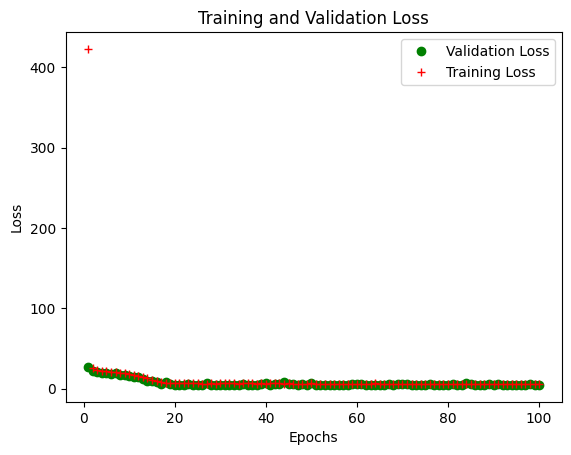

In [20]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_loss, 'go', label='Validation Loss')
plt.plot(epochs, training_loss, 'r+', label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

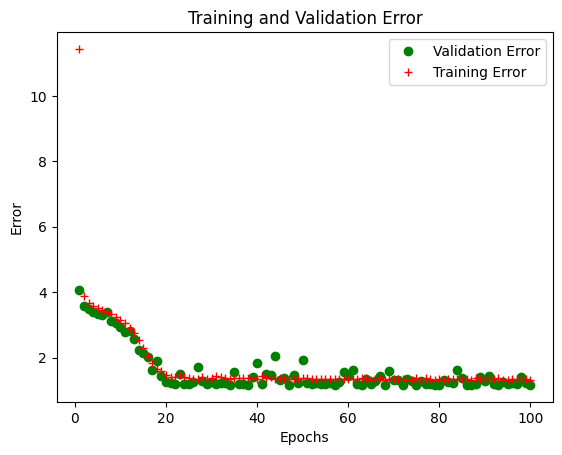

In [21]:
train_error = history.history['mean_absolute_error']
validation_error = history.history['val_mean_absolute_error']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_error, 'go', label='Validation Error')
plt.plot(epochs, train_error, 'r+', label='Training Error')
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [24]:
test_predicted = small_model.predict(x_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


In [31]:
for index in range(len(test_predicted[:10])):
    print(f'\nReal value: {y_test[index]}')
    print(f'Predicted value: {test_predicted[index]}')
# print(f'Predicted value: {test_predicted[100]}')


Real value: 67
Predicted value: [66.75945]

Real value: 65
Predicted value: [64.2161]

Real value: 64
Predicted value: [64.15002]

Real value: 63
Predicted value: [61.807854]

Real value: 70
Predicted value: [70.17497]

Real value: 66
Predicted value: [67.925064]

Real value: 66
Predicted value: [68.85827]

Real value: 71
Predicted value: [71.31088]

Real value: 65
Predicted value: [63.02083]

Real value: 68
Predicted value: [67.98481]


### Small Model with Regularization and Dropout

In [56]:
from keras import regularizers
from keras.layers import Dense, Dropout, Input

small_model_l2_dropout = models.Sequential()

# The input shape is the number of features because keras needs to know how many dimensions the input has
small_model_l2_dropout.add(Input(shape=(x_train.shape[1],)))
small_model_l2_dropout.add(Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
small_model_l2_dropout.add(Dropout(0.5))
small_model_l2_dropout.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
small_model_l2_dropout.add(Dropout(0.5))
small_model_l2_dropout.add(Dense(1, kernel_regularizer=regularizers.l2(0.001), activation='linear'))

In [57]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

small_model_l2_dropout.compile(optimizer=optimizer, 
              loss='mean_squared_error', 
              metrics=['mean_absolute_error'])

In [60]:
history_l2_dropout = small_model_l2_dropout.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 549.6049 - mean_absolute_error: 19.1935 - val_loss: 97.5764 - val_mean_absolute_error: 9.3937
Epoch 2/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 537.4109 - mean_absolute_error: 18.9565 - val_loss: 56.3189 - val_mean_absolute_error: 6.8422
Epoch 3/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 531.7443 - mean_absolute_error: 18.7695 - val_loss: 71.0759 - val_mean_absolute_error: 7.8937
Epoch 4/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 512.8702 - mean_absolute_error: 18.4153 - val_loss: 78.1091 - val_mean_absolute_error: 8.3802
Epoch 5/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 508.4712 - mean_absolute_error: 18.3687 - val_loss: 92.0139 - val_mean_absolute_error: 9.2089
Epoch 6/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 497.8823 - mean_absolute_error: 18.1595 - val_loss: 53.6029 - val_mean_absolute_error: 6.7751
Epoch 7/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - l

### Small Model with Regularization results

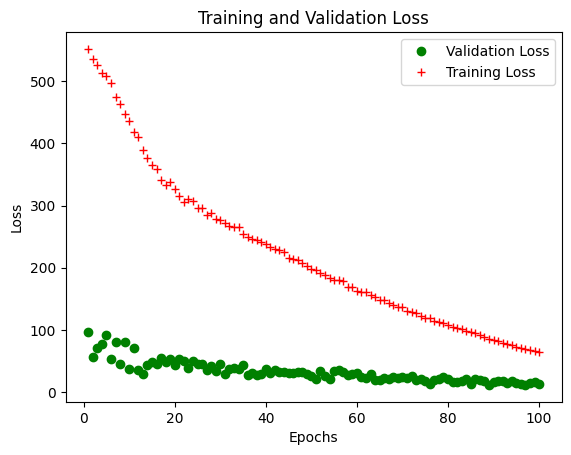

In [61]:
import matplotlib.pyplot as plt

training_loss = history_l2_dropout.history['loss']
validation_loss = history_l2_dropout.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_loss, 'go', label='Validation Loss')
plt.plot(epochs, training_loss, 'r+', label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

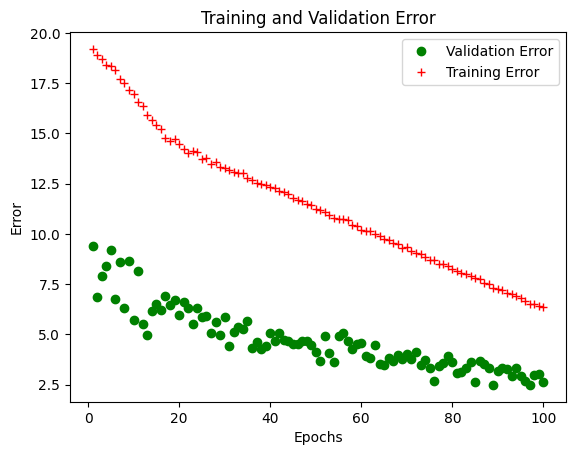

In [62]:
train_error = history_l2_dropout.history['mean_absolute_error']
validation_error = history_l2_dropout.history['val_mean_absolute_error']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_error, 'go', label='Validation Error')
plt.plot(epochs, train_error, 'r+', label='Training Error')
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [63]:
test_predicted_l2_dropout = small_model_l2_dropout.predict(x_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


In [64]:
for index in range(len(test_predicted_l2_dropout[:10])):
    print(f'\nReal value: {y_test[index]}')
    print(f'Predicted value: {test_predicted_l2_dropout[index]}')


Real value: 67
Predicted value: [64.68041]

Real value: 65
Predicted value: [64.19956]

Real value: 64
Predicted value: [63.876232]

Real value: 63
Predicted value: [63.26249]

Real value: 70
Predicted value: [67.05348]

Real value: 66
Predicted value: [66.04225]

Real value: 66
Predicted value: [65.915794]

Real value: 71
Predicted value: [67.652336]

Real value: 65
Predicted value: [63.361298]

Real value: 68
Predicted value: [66.355125]


---

## Bayesian Optimization

### Finding Best Hyperparameters

Let's find the better values for the model hyperparameters.

In [68]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam

# search space
param_space = [
    Real(1e-6, 1e-1, name='learning_rate', prior='log-uniform'),
    Real(0.1, 0.9, name='dropout_rate'),
    Integer(10, 100, name='epochs'),
    Integer(16, 64, name='dense_units_1'),
    Integer(16, 64, name='dense_units_2')
]

This is the objective function. After finding the better hyperparameters values, the `objective()` function will be called to train a model with those values:

In [71]:
@use_named_args(param_space)
def objective(learning_rate, dropout_rate, epochs, dense_units_1, dense_units_2):
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],)))
    model.add(Dense(dense_units_1, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units_2, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.001), activation='linear'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    
    history = model.fit(x_train, y_train, batch_size=32, epochs=epochs, verbose=0, validation_data=(x_val, y_val))
    
    loss_test, mae_test = model.evaluate(x_test, y_test, verbose=0)
    
    return loss_test

In [72]:
res = gp_minimize(objective, param_space, n_calls=50, random_state=0)

Mejores hiperparámetros encontrados:
Learning rate: 0.04992792927397439
Dropout rate: 0.18128765768009508
Units in Dense Layer 1: 10
Units in Dense Layer 2: 64


The best hyperparameters are:

In [73]:
print("Mejores hiperparámetros encontrados:")
print(f"Learning rate: {res.x[0]}")
print(f"Dropout rate: {res.x[1]}")
print(f"epchs: {res.x[2]}")
print(f"Units in Dense Layer 1: {res.x[3]}")
print(f"Units in Dense Layer 2: {res.x[4]}")

Mejores hiperparámetros encontrados:
Learning rate: 0.04992792927397439
Dropout rate: 0.18128765768009508
epchs: 10
Units in Dense Layer 1: 64
Units in Dense Layer 2: 16


### Optimized Model

Now, let's create a model using the values we've just found as the best ones.

In [74]:
from keras import regularizers
from keras.layers import Dense, Dropout, Input

small_model_optimized = models.Sequential()

# The input shape is the number of features because keras needs to know how many dimensions the input has
small_model_optimized.add(Input(shape=(x_train.shape[1],)))
small_model_optimized.add(Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
small_model_optimized.add(Dropout(0.18128765768009508))
small_model_optimized.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
small_model_optimized.add(Dropout(0.18128765768009508))
small_model_optimized.add(Dense(1, kernel_regularizer=regularizers.l2(0.001), activation='linear'))

from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.04992792927397439)

small_model_optimized.compile(optimizer=optimizer, 
              loss='mean_squared_error', 
              metrics=['mean_absolute_error'])

history_optimized = small_model_optimized.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 366.9263 - mean_absolute_error: 14.7343 - val_loss: 58.0996 - val_mean_absolute_error: 7.0654
Epoch 2/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 165.9507 - mean_absolute_error: 10.2320 - val_loss: 18.8136 - val_mean_absolute_error: 3.6956
Epoch 3/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 101.0708 - mean_absolute_error: 7.9296 - val_loss: 24.3671 - val_mean_absolute_error: 4.0223
Epoch 4/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 66.3944 - mean_absolute_error: 6.3848 - val_loss: 16.4232 - val_mean_absolute_error: 3.0086
Epoch 5/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 45.1777 - mean_absolute_error: 5.2405 - val_loss: 14.4442 - val_mean_absolute_error: 2.8340
Epoch 6/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 35.8983 - mean_absolute_error: 4.6378 - val_loss: 14.2375 - val_mean_absolute_error: 2.8086
Epoch 7/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - loss: 27.2809 - m

### Optimized Model results

Let's compare the results of the optimized model.

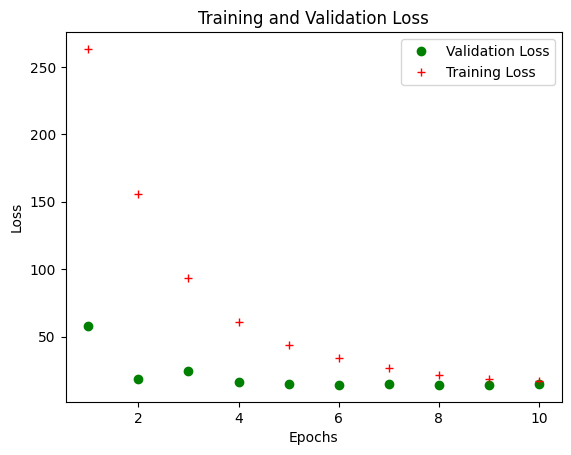

In [75]:
import matplotlib.pyplot as plt

training_loss = history_optimized.history['loss']
validation_loss = history_optimized.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_loss, 'go', label='Validation Loss')
plt.plot(epochs, training_loss, 'r+', label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

With respect to the results obtained with the other models, we can see that the optimized model has achieved a lower loss at the training time. However the validation loss remains quite similar. 

Furthermore, the optimized model seems to have reached a sweet spot between validation loss and training loss, which is a positive sign, as it indicates that the model is not overfitting. This suggests that we can tune it a little further to improve its performance.

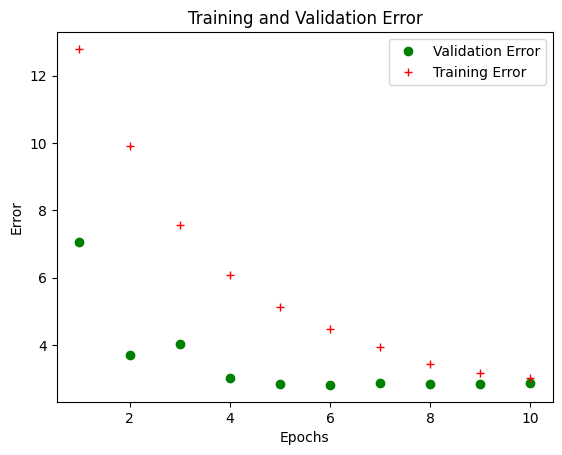

In [76]:
train_error = history_optimized.history['mean_absolute_error']
validation_error = history_optimized.history['val_mean_absolute_error']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, validation_error, 'go', label='Validation Error')
plt.plot(epochs, train_error, 'r+', label='Training Error')
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

The behavior of the curves indicates that the optimized model is achieving improved accuracy in both the training and validation sets. The fact that the validation MAE does not continue to decrease significantly after the fourth epoch suggests that the model has reached an acceptable performance point and that training for more epochs will probably not improve the results. This is a positive sign that the model is not overfitting, although it would be advisable to make fine adjustments to the hyperparameters to explore possible improvements.

In [77]:
test_predicted_optimized = small_model_optimized.predict(x_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


In [78]:
for index in range(len(test_predicted_optimized[:10])):
    print(f'\nReal value: {y_test[index]}')
    print(f'Predicted value: {test_predicted_optimized[index]}')


Real value: 67
Predicted value: [68.03044]

Real value: 65
Predicted value: [68.03044]

Real value: 64
Predicted value: [68.03044]

Real value: 63
Predicted value: [68.03044]

Real value: 70
Predicted value: [68.03044]

Real value: 66
Predicted value: [68.03044]

Real value: 66
Predicted value: [68.03044]

Real value: 71
Predicted value: [68.03044]

Real value: 65
Predicted value: [68.03044]

Real value: 68
Predicted value: [68.03044]
